# Analisis Sentimen pada Ulasan Aplikasi SATUSEHAT Mobile di Google Play Store

Notebook ini menganalisis sentimen dalam ulasan pengguna terhadap aplikasi SATUSEHAT Mobile.
Analisis ini membantu memahami kepuasan pengguna dan mengidentifikasi area yang perlu ditingkatkan.

Data diambil dari Google Play Store menggunakan library google-play-scraper.

## Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Utility libraries
import joblib
import pickle
import requests
from io import StringIO
import csv
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Nilai seed untuk memastikan hasil yang konsisten
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Download NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Dataset

In [3]:
# Load dataset
file_path = "satusehat_reviews.csv"
reviews_df = pd.read_csv(file_path)

reviews_df.head()

,content,score
0,"Aplikasi tidak bisa diakses, berulang kali ing...",1
1,Stuck di verifikasi ngelag ga bisa masuk.. apa...,2
2,"Aplikasi nya tidak siap, banyak bug nya, mulai...",1
3,"Haduh,, aplikasi pemerintah lagi. Apresiasi ad...",1
4,Aplikasi tidak jelas dan belum siap. Sudah mas...,1


## Exploratory Data Analysis

In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  100000 non-null  object
 1   score    100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
# Cek data yang hilang
print("Missing values in each column:")
print(reviews_df.isnull().sum())

Missing values in each column:
content    0
score      0
dtype: int64


In [6]:
# Cek duplikasi data
duplicate_count = reviews_df.duplicated().sum()
print(f"Number of duplicate reviews: {duplicate_count}")

Number of duplicate reviews: 303


In [7]:
# Hapus duplikasi
reviews_df.drop_duplicates(inplace=True)
print("Dataset after removing duplicates:")
reviews_df.info()

Dataset after removing duplicates:
<class 'pandas.core.frame.DataFrame'>
Index: 99697 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  99697 non-null  object
 1   score    99697 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


## Visualisasi Awal

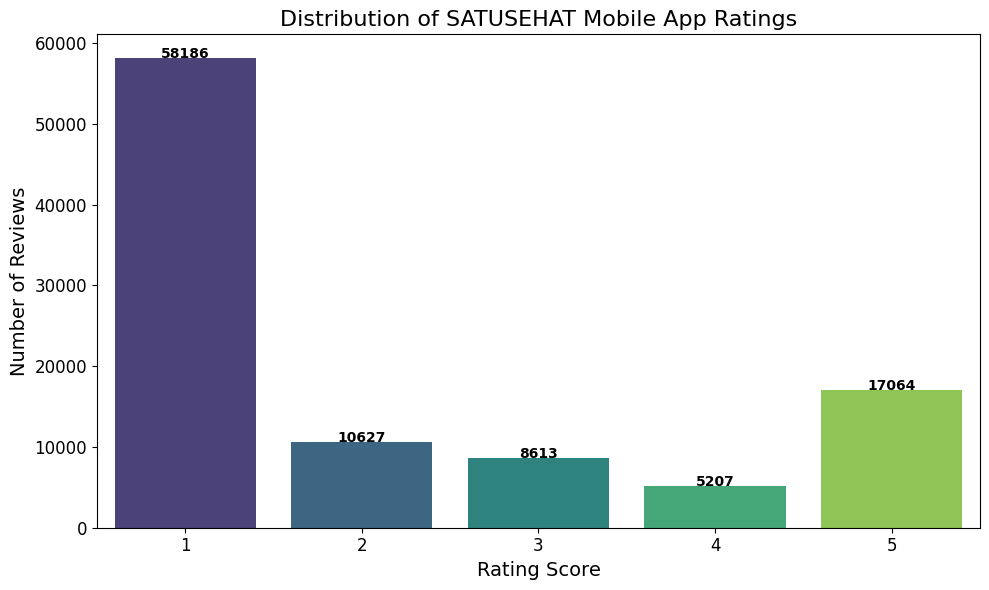

In [8]:
custom_palette = sns.color_palette("viridis", 5)

# Visualisasi distribusi rating user
plt.figure(figsize=(10, 6))
rating_counts = reviews_df['score'].value_counts().sort_index()
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette=custom_palette)

for i, count in enumerate(rating_counts.values):
    ax.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.title("Distribution of SATUSEHAT Mobile App Ratings", fontsize=16)
plt.xlabel("Rating Score", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Visualisasi menampilkan distribusi ulasan pengguna aplikasi SATUSEHAT berdasarkan skor rating (1-5):

- Rating 1 mendominasi dengan 58.186 ulasan
- Rating 5 di posisi kedua dengan 17.064 ulasan
- Rating 2, 3, dan 4 memiliki jumlah lebih sedikit (10.627, 8.613, dan 5.207)

Pola distribusi menunjukkan polarisasi pendapat pengguna sangat didominasi oleh rating terendah

In [9]:
# Jumlah user review per rating
print("Number of reviews by rating:")
print(reviews_df['score'].value_counts().sort_index())

Number of reviews by rating:
score
1    58186
2    10627
3     8613
4     5207
5    17064
Name: count, dtype: int64


## Text Preprocessing

Untuk kebutuhan keseimbangan distribusi data dan mencegah overfit, pada bagian di bawah ini adalah pemangkasan data

In [10]:
# Simpan hanya 40000 data ulasan bintang 1
one_star_sample = reviews_df[reviews_df['score'] == 1].sample(40000, random_state=42)
other_reviews = reviews_df[reviews_df['score'] != 1]
reviews_df = pd.concat([one_star_sample, other_reviews]).reset_index(drop=True)

# Distribusi sesudah pemangkasan
print(reviews_df['score'].value_counts())

score
1    40000
5    17064
2    10627
3     8613
4     5207
Name: count, dtype: int64


In [13]:
# Fungsi untuk pembersihan teks
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Remove hashtags
    text = re.sub(r"http\S+", '', text)  # Remove links
    text = re.sub(r'[0-9]+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters

    text = text.replace('\n', ' ')  # Replace new line with space
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove leading/trailing spaces
    return text


# Fungsi untuk konversi ke huruf kecil
def convert_to_lowercase(text):
    return text.lower()


# Split teks menjadi token/kata
def tokenize_text(text):
    return word_tokenize(text)


# Fungsi untuk menghapus stopwords dari list token
def remove_stopwords(tokens):
    indo_stopwords = set(stopwords.words('indonesian'))
    eng_stopwords = set(stopwords.words('english'))

    all_stopwords = indo_stopwords.union(eng_stopwords)

    # Menambah stopwords tambahan
    all_stopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi',
        'woii', 'woy'
    ])

    return [word for word in tokens if word not in all_stopwords]


# Menggabungkan list token menjadi satu kalimat
def convert_to_sentence(tokens):
    return ' '.join(tokens)


# Load data slang Bahasa Indonesia
def load_slang_dictionary():

    slang_dict = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

    return slang_dict


# Fungsi untuk mengganti kata slang dalam teks menjadi bentuk baku
def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(normalized_words)


slang_dictionary = load_slang_dictionary()

In [14]:
# Menerapkah langkah preprocessing pada fungsi yang sudah didefinisikan
reviews_df['cleaned_text'] = reviews_df['content'].apply(clean_text)
reviews_df['lowercased_text'] = reviews_df['cleaned_text'].apply(convert_to_lowercase)
reviews_df['normalized_text'] = reviews_df['lowercased_text'].apply(
    lambda x: normalize_slang(x, slang_dictionary)
)
reviews_df['tokenized_text'] = reviews_df['normalized_text'].apply(tokenize_text)
reviews_df['filtered_text'] = reviews_df['tokenized_text'].apply(remove_stopwords)
reviews_df['processed_text'] = reviews_df['filtered_text'].apply(convert_to_sentence)

reviews_df[['content', 'processed_text']].head()

,content,processed_text
0,tolong di perbaiki udh vaksin ko mau masuk apl...,tolong perbaiki udh vaksin ko masuk aplikasi v...
1,"Aplikasi apaan nih, login berkali "" baru bisa,...",aplikasi login berkali scene kadang disuruh lo...
2,Begitu ganti ke aplikasi satu sehat Ternyata s...,ganti aplikasi sehat sulit membuka bikin orang...
3,"Di Update bukan tambah bagus, tp malah tambah ...",update bagus
4,"Lelet Kali Apk Ini. Update lah,Susah Buat Saya...",lambat kali apk update lahsusah mengakses


In [15]:
# Hasil preprocessing
reviews_df.head()

,content,score,cleaned_text,lowercased_text,normalized_text,tokenized_text,filtered_text,processed_text
0,tolong di perbaiki udh vaksin ko mau masuk apl...,1,tolong di perbaiki udh vaksin ko mau masuk apl...,tolong di perbaiki udh vaksin ko mau masuk apl...,tolong di perbaiki udh vaksin ko mau masuk apl...,"[tolong, di, perbaiki, udh, vaksin, ko, mau, m...","[tolong, perbaiki, udh, vaksin, ko, masuk, apl...",tolong perbaiki udh vaksin ko masuk aplikasi v...
1,"Aplikasi apaan nih, login berkali "" baru bisa,...",1,Aplikasi apaan nih login berkali baru bisa sc...,aplikasi apaan nih login berkali baru bisa sc...,aplikasi apa ini login berkali baru bisa scene...,"[aplikasi, apa, ini, login, berkali, baru, bis...","[aplikasi, login, berkali, scene, kadang, disu...",aplikasi login berkali scene kadang disuruh lo...
2,Begitu ganti ke aplikasi satu sehat Ternyata s...,1,Begitu ganti ke aplikasi satu sehat Ternyata s...,begitu ganti ke aplikasi satu sehat ternyata s...,begitu ganti ke aplikasi satu sehat ternyata s...,"[begitu, ganti, ke, aplikasi, satu, sehat, ter...","[ganti, aplikasi, sehat, sulit, membuka, bikin...",ganti aplikasi sehat sulit membuka bikin orang...
3,"Di Update bukan tambah bagus, tp malah tambah ...",1,Di Update bukan tambah bagus tp malah tambah g...,di update bukan tambah bagus tp malah tambah g...,di update bukan tambah bagus tapi bahkan tamba...,"[di, update, bukan, tambah, bagus, tapi, bahka...","[update, bagus]",update bagus
4,"Lelet Kali Apk Ini. Update lah,Susah Buat Saya...",1,Lelet Kali Apk Ini Update lahSusah Buat Saya M...,lelet kali apk ini update lahsusah buat saya m...,lambat kali apk ini update lahsusah buat saya ...,"[lambat, kali, apk, ini, update, lahsusah, bua...","[lambat, kali, apk, update, lahsusah, mengakses]",lambat kali apk update lahsusah mengakses


## Lexicon-Based Sentiment Analysis

In [16]:
# Fungsi load data lexicon positive dan negative
def load_lexicon(lexicon_type):
    lexicon = {}
    url = f'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_{lexicon_type}.csv'

    response = requests.get(url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            lexicon[row[0]] = int(row[1])
    else:
        print(f"Failed to fetch {lexicon_type} lexicon data")

    return lexicon


# Fungsi kalkuasi skor sentimen
def analyze_sentiment(tokens, positive_lexicon, negative_lexicon):
    score = 0

    # Skor positive
    for word in tokens:
        if word in positive_lexicon:
            score += positive_lexicon[word]

    # Skor negative
    for word in tokens:
        if word in negative_lexicon:
            score += negative_lexicon[word]

    # Menentukan label sentimen
    if score > 0:
        sentiment = 'positive'
    elif score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return score, sentiment

In [17]:
# Load lexicon
positive_lexicon = load_lexicon('positive')
negative_lexicon = load_lexicon('negative')

# Menerapkan analisis sentimen pada ulasan
sentiment_results = reviews_df['filtered_text'].apply(
    lambda x: analyze_sentiment(x, positive_lexicon, negative_lexicon)
)

In [18]:
reviews_df['sentiment_score'] = [result[0] for result in sentiment_results] # Menyimpan skor numerik sentimen
reviews_df['sentiment'] = [result[1] for result in sentiment_results] # Menyimpan label sentimen (positif/negatif)

In [20]:
# Distribusi sentimen
print("Sentiment Distribution:")
print(reviews_df['sentiment'].value_counts())

Sentiment Distribution:
sentiment
negative    52338
positive    18787
neutral     10386
Name: count, dtype: int64


### Sentiment Visualization

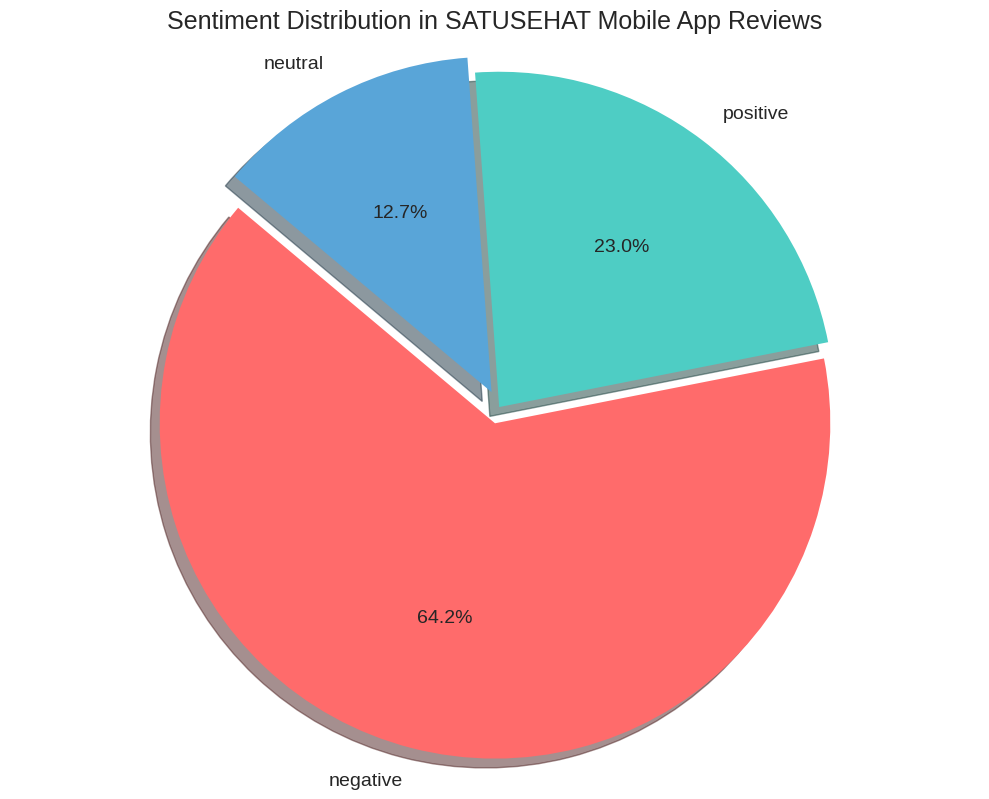

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Pie chart distribusi sentimen
sentiment_counts = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True,
    explode=(0.05, 0, 0.05),
    colors=['#FF6B6B', '#4ECDC4', '#59A5D8'],
    textprops={'fontsize': 14}
)
plt.title('Sentiment Distribution in SATUSEHAT Mobile App Reviews', fontsize=18)
plt.axis('equal')
plt.tight_layout()
plt.show()

Diagram pie menunjukkan hasil analisis sentimen pada ulasan aplikasi mobile SATUSEHAT:

- Sentimen negatif sangat dominan (64.2%)
- Sentimen positif di urutan kedua (23.0%)
- Sentimen netral paling sedikit (12.7%)

Visualisasi mengkonfirmasi tingginya tingkat ketidakpuasan pengguna aplikasi

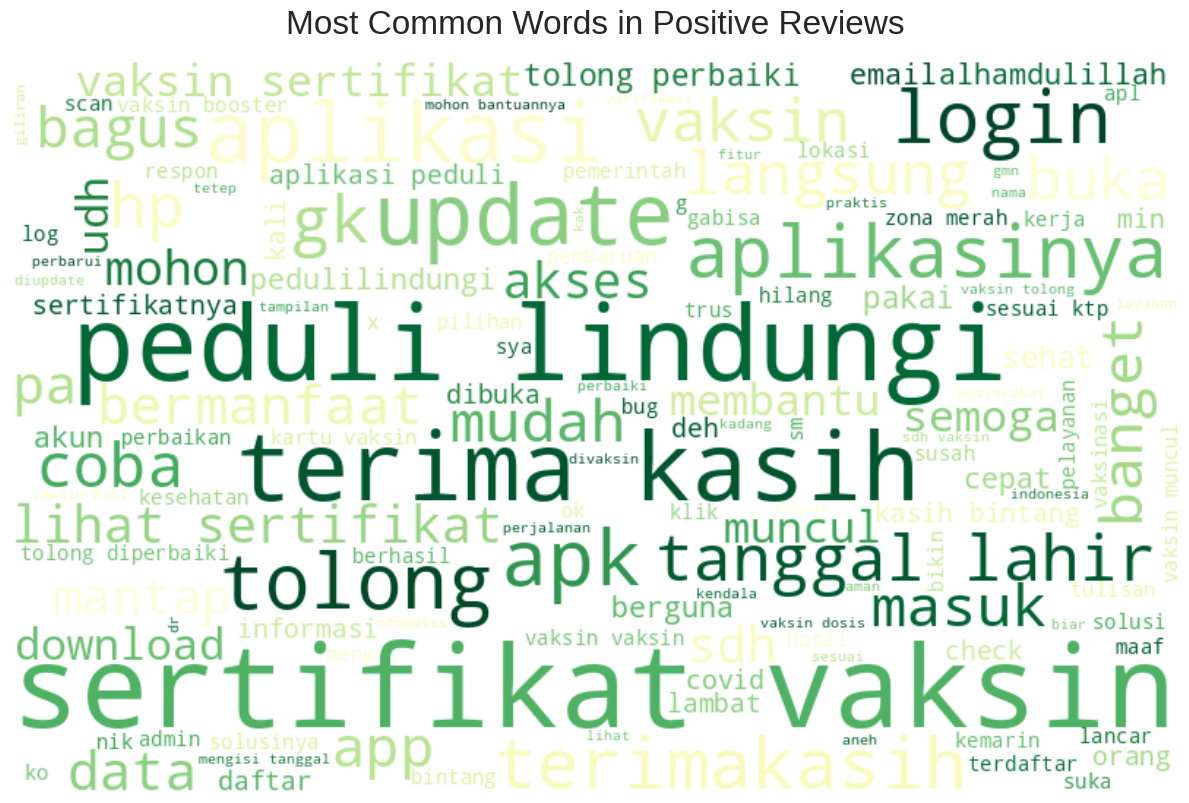

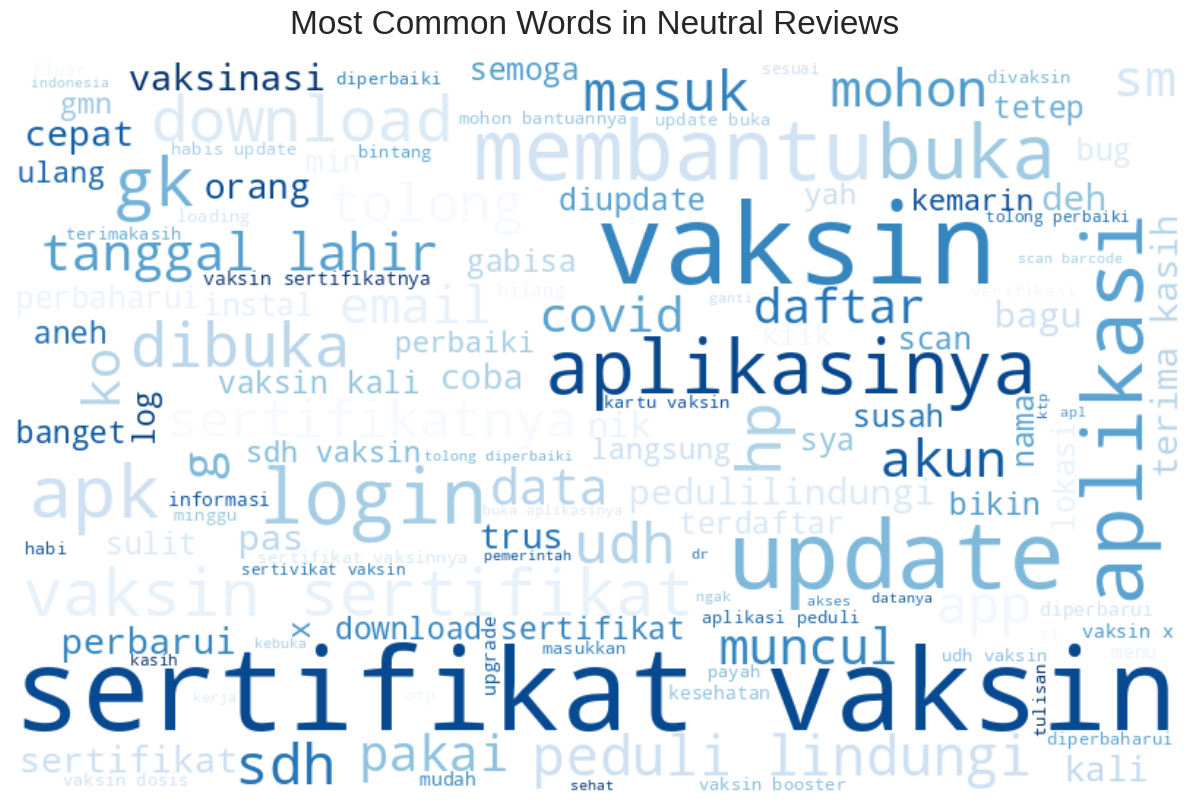

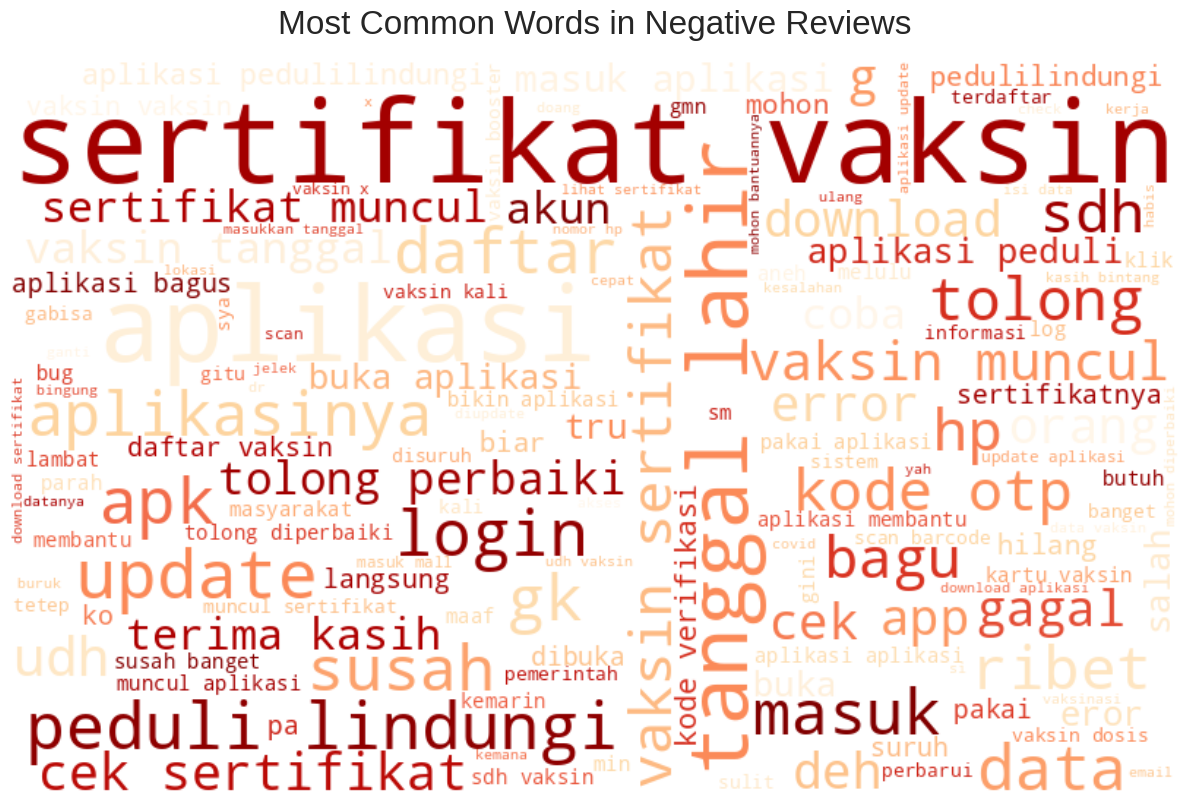

In [22]:
# 2. Word clouds for each sentiment category

def generate_wordcloud(text_data, title, colormap='viridis'):
    """
    Generate and display a word cloud from text data

    Args:
        text_data (str): Combined text for word cloud
        title (str): Title for the word cloud
        colormap (str): Matplotlib colormap name
    """
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(
        width=800,
        height=500,
        background_color='white',
        colormap=colormap,
        max_font_size=150,
        min_font_size=10,
        max_words=200,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=24, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Generate word clouds for each sentiment category
for sentiment, colormap in [
    ('positive', 'YlGn'),
    ('neutral', 'Blues'),
    ('negative', 'OrRd')
]:
    # Filter reviews by sentiment
    filtered_df = reviews_df[reviews_df['sentiment'] == sentiment]

    # Combine all words from filtered reviews
    all_words = ' '.join([' '.join(tokens) for tokens in filtered_df['filtered_text']])

    # Generate word cloud
    generate_wordcloud(
        all_words,
        f'Most Common Words in {sentiment.capitalize()} Reviews',
        colormap
    )


Analisis Word Cloud Berdasarkan Sentimen Ulasan SATUSEHAT

- **Ulasan Netral**:
Word cloud menampilkan kata-kata dominan pada ulasan netral dengan fokus pada "sertifikat", "vaksin", dan "aplikasinya". Kata lain yang menonjol termasuk "update", "login", dan "tanggal lahir", mengindikasikan perhatian pengguna pada fungsionalitas dasar dan dokumentasi vaksinasi.

- **Ulasan Positif**:
Visualisasi menunjukkan kata-kata positif seperti "terima kasih", "bagus", dan "peduli lindungi". Kata "tolong" dan "perbaiki" tetap muncul namun dengan tone lebih konstruktif. Pengguna juga menyebutkan "alhamdulillah" sebagai ekspresi kepuasan terhadap beberapa fitur aplikasi.

- **Ulasan Negatif**:
Word cloud ulasan negatif menampilkan kata "sertifikat" dan "vaksin" dengan ukuran sangat dominan, mengindikasikan masalah utama. Kata "gagal", "error", dan "susah" muncul secara jelas, menunjukkan frustrasi pengguna. Permintaan "tolong perbaiki" menandakan harapan untuk perbaikan aplikasi.

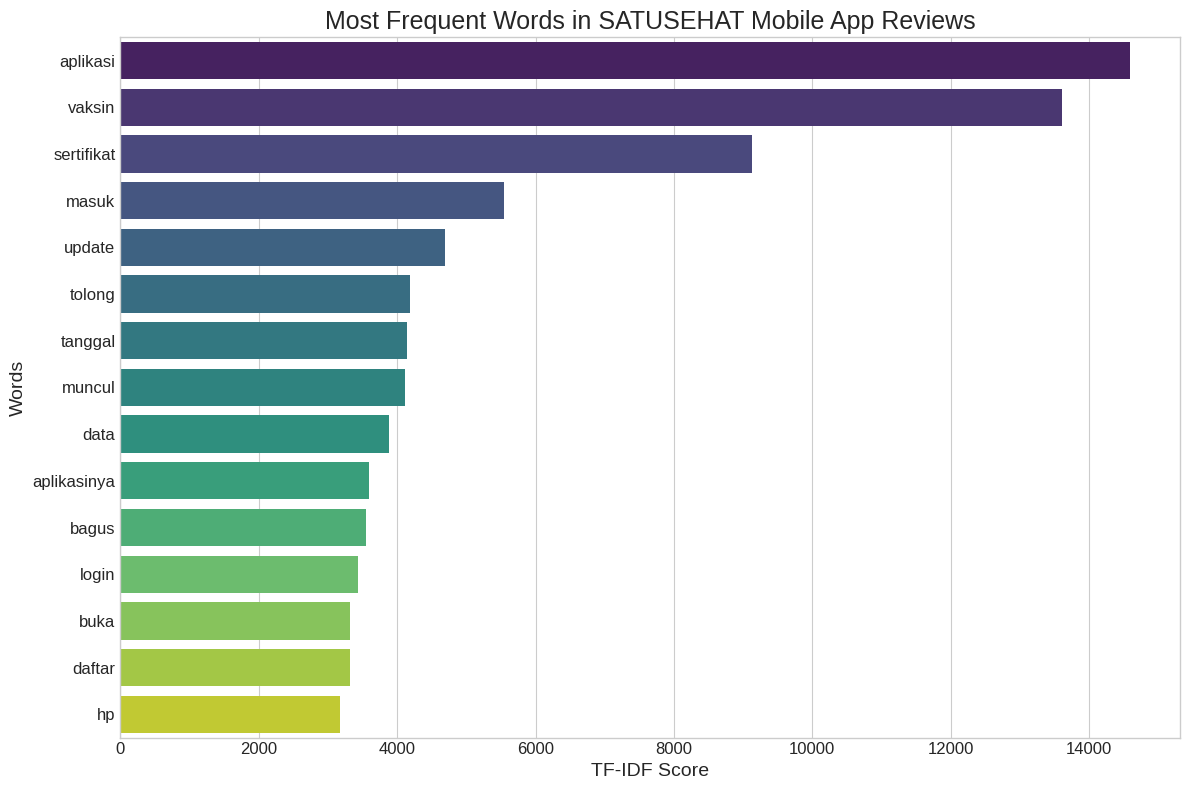

In [23]:
# 3. Visualisasi kata yang sering muncul
vectorizer = TfidfVectorizer(max_features=20)
X = vectorizer.fit_transform(reviews_df['processed_text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq = tfidf_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=word_freq.values[:15], y=word_freq.index[:15], palette='viridis')
plt.title('Most Frequent Words in SATUSEHAT Mobile App Reviews', fontsize=18)
plt.xlabel('TF-IDF Score', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Visualisasi menampilkan frekuensi kata dalam ulasan aplikasi SATUSEHAT berdasarkan skor TF-IDF:

- "Aplikasi" mendominasi dengan skor tertinggi (±14.000)
- "Vaksin" berada di posisi kedua (±13.000)
- "Sertifikat" di posisi ketiga (±9.000)
- Kata-kata terkait fungsionalitas seperti "masuk", "update", dan "login" juga sering muncul
- Mencerminkan fokus utama pengguna pada permasalahan terkait dokumentasi vaksinasi dan akses aplikasi

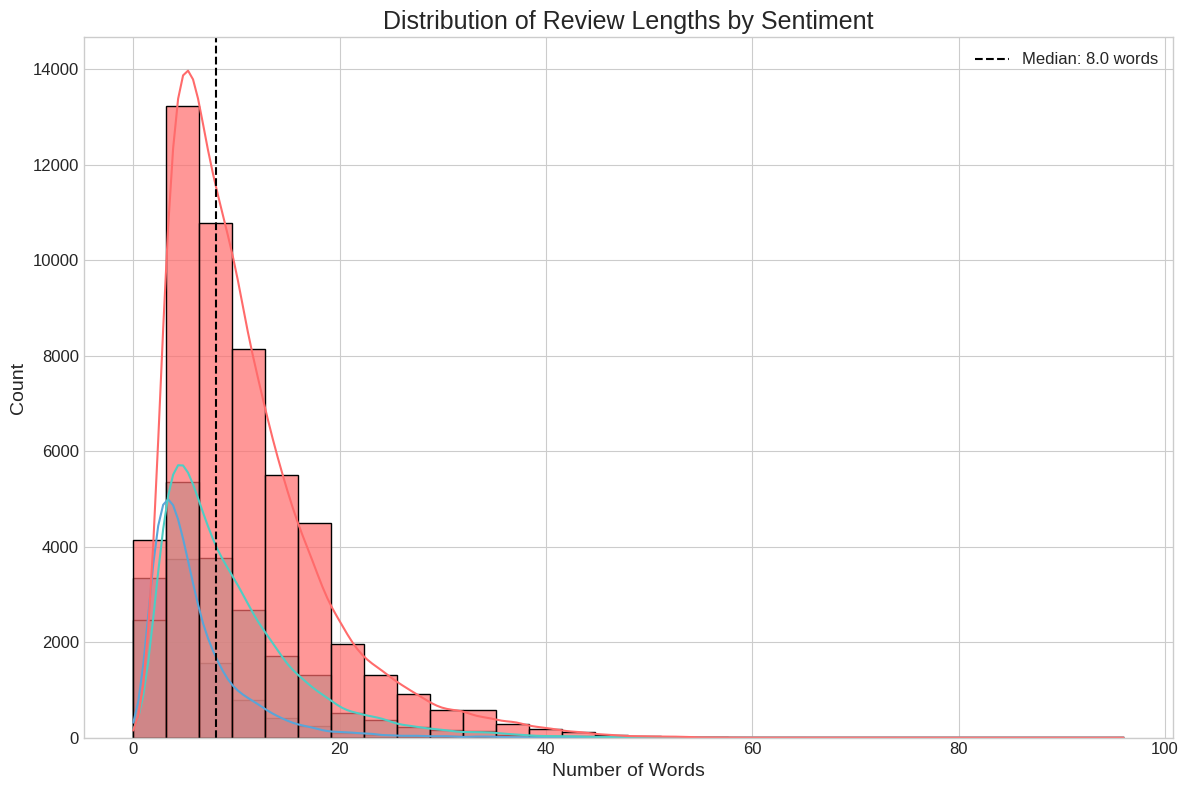

In [24]:
# 4. Distribusi panjang ulasan
plt.figure(figsize=(12, 8))
reviews_df['text_length'] = reviews_df['processed_text'].apply(lambda x: len(x.split()))

g = sns.histplot(
    data=reviews_df,
    x='text_length',
    hue='sentiment',
    bins=30,
    palette=['#FF6B6B', '#4ECDC4', '#59A5D8'],
    alpha=0.7,
    kde=True
)

plt.title('Distribution of Review Lengths by Sentiment', fontsize=18)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=reviews_df['text_length'].median(), color='black', linestyle='--', label=f'Median: {reviews_df["text_length"].median()} words')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Grafik menunjukkan panjang ulasan (jumlah kata) berdasarkan kategori sentimen:

- Median panjang ulasan adalah 8 kata (ditandai dengan garis putus-putus vertikal)
- Mayoritas ulasan sangat singkat (0-10 kata), dengan puncak pada 5-8 kata
- Warna merah menunjukkan sentimen negatif yang dominan di hampir semua kategori panjang
- Warna biru (ulasan netral) cenderung lebih pendek dan terkonsentrasi di 0-15 kata
- Ulasan lebih panjang (>20 kata) didominasi oleh sentimen negatif, menunjukkan pengguna yang tidak puas cenderung memberikan ulasan lebih detail

## Feature Extraction

In [25]:
# Kolom 'processed_text' sebagai fitur (X) dan 'sentiment' sebagai label (y)
X = reviews_df['processed_text']
y = reviews_df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

### TF-IDF

In [26]:
# Transformasi teks ke vektor angka menggunakan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF feature dimensions: {X_tfidf.shape}")

TF-IDF feature dimensions: (81511, 10000)


### Tokenizer for Keras Embedding

In [27]:
# Inisialisasi tokenizer
sequence_tokenizer = Tokenizer(num_words=10000)
sequence_tokenizer.fit_on_texts(X)

# Konversi teks menjadi urutan numerik
X_sequences = sequence_tokenizer.texts_to_sequences(X)

# Menyamakan panjang urutan dengan padding (maksimal 100 kata)
MAX_SEQUENCE_LENGTH = 100
X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Model Training

### LSTM

In [28]:
# Membagi data menjadi training set (80%) dan test (20%)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_padded, y, test_size=0.2, random_state=RANDOM_SEED
)

# Membagi training set menjadi training set (87.5%) dan validasi (12.5%)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_lstm, y_train_lstm, test_size=0.125, random_state=RANDOM_SEED
)

print("LSTM Data Split:")
print(f"Training set: {X_train_lstm.shape[0]} samples")
print(f"Validation set: {X_val_lstm.shape[0]} samples")
print(f"Test set: {X_test_lstm.shape[0]} samples")


LSTM Data Split:
Training set: 57057 samples
Validation set: 8151 samples
Test set: 16303 samples


In [30]:
# LSTM Model
lstm_model = Sequential([
    # Input embedding layer
    Embedding(input_dim=10000, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),

    # Regularization
    SpatialDropout1D(0.3),

    # LSTM layer
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    # Output layer (3 kelas)
    Dense(3, activation='softmax')
])

# Compile
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate 0.001
    metrics=['accuracy']
)

# Callbacks untuk mengontrol proses training
early_stopping = EarlyStopping(
    monitor='val_loss',           # Memantau loss validasi
    patience=3,                   # Berhenti jika tidak ada perbaikan selama 3 epoch
    restore_best_weights=True     # Mengembalikan bobot terbaik setelah pelatihan
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,     # Mengurangi learning rate setengahnya
    patience=2,     # Menunggu 2 epoch sebelum mengurangi learning rate
    min_lr=0.0001   # Batas minimal learning rate
)

callbacks = [early_stopping, reduce_lr]

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=10,
    batch_size=128,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 182s 396ms/step - accuracy: 0.7345 - loss: 0.6701 - val_accuracy: 0.9193 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 166s 316ms/step - accuracy: 0.9185 - loss: 0.2323 - val_accuracy: 0.9363 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accuracy: 0.9429 - loss: 0.1610 - val_accuracy: 0.9427 - val_loss: 0.1692 - learning_rate: 0.0010
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.9526 - loss: 0.1301 - val_accuracy: 0.9465 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.9587 - loss: 0.1074 - val_accuracy: 0.9457 - val_loss: 0.1669 - learning_rate: 0.0010
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 140s 313ms/step - accuracy: 0.9643 - loss: 0.0964 - val_accuracy: 0.9459 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accura

### Random Forest

In [31]:
# Split data untuk Random Forest model
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=RANDOM_SEED
)

print("Random Forest Data Split:")
print(f"Training set: {X_train_rf.shape[0]} samples")
print(f"Test set: {X_test_rf.shape[0]} samples")

Random Forest Data Split:
Training set: 57057 samples
Test set: 24454 samples


In [47]:
# Inisialisasi model Random Forest dengan penyesuaian hyperparameter
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)

### Support Vector Machine

In [33]:
# Split data untuk SVM model
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=RANDOM_SEED
)

print("SVM Data Split:")
print(f"Training set: {X_train_svm.shape[0]} samples")
print(f"Test set: {X_test_svm.shape[0]} samples")

SVM Data Split:
Training set: 57057 samples
Test set: 24454 samples


In [34]:
# Inisialisasi SVM model
svm_model = SVC(
    kernel='linear',    # Kernel linear daripada rbf untuk mempercepat training
    C=1.0,
    probability=True,
    random_state=RANDOM_SEED
)

svm_model.fit(X_train_svm, y_train_svm)

y_pred_svm = svm_model.predict(X_test_svm)

## Model Evaluation

In [35]:
# Fungsi untuk evaluasi performa model dan menampilkan confusion matrix
def evaluate_model(y_true, y_pred, model_name):
    # Hitung akurasi
    accuracy = accuracy_score(y_true, y_pred)

    # Tampilkan hasil klasifikasi
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Kalkulasi matriks setiap kelas
    for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

        print(f"\nClass: {label}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-score:  {f1:.4f}")

### LSTM Evaluation

510/510 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step


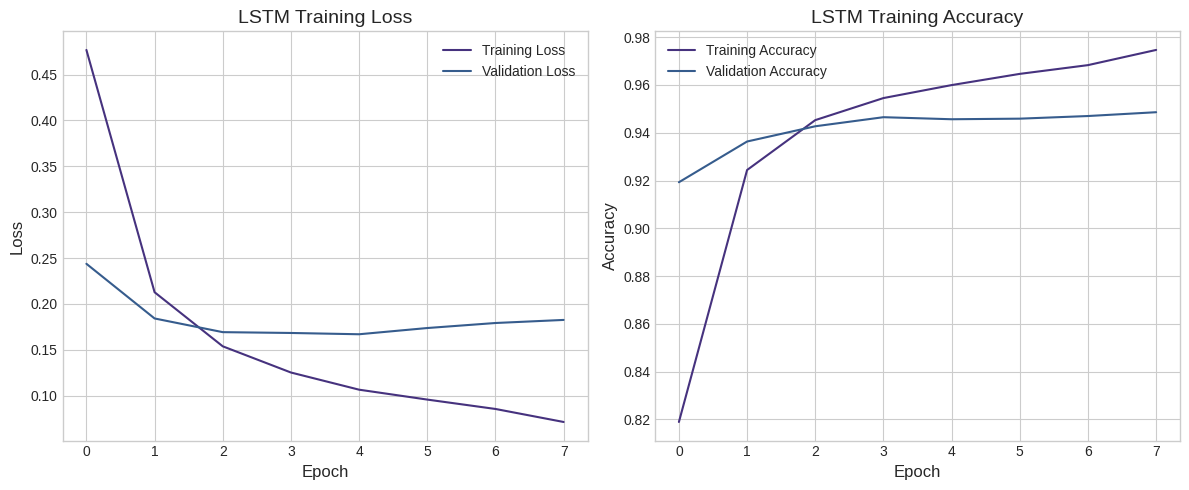

In [36]:
# Evaluasi LSTM model
# Prediksi untuk test data
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)

# Visualisasi training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

LSTM Training Loss:

- Training loss menurun secara signifikan dari nilai awal sekitar 0.47 hingga 0.07 pada epoch ke-7
- Validation loss turun dengan cepat pada awal, kemudian stabil di sekitar 0.17-0.19
- Mulai epoch ke-3, validation loss relatif stabil namun sedikit meningkat pada epoch terakhir

LSTM Training Accuracy:

- Training accuracy meningkat dari sekitar 0.82 menjadi 0.97 pada epoch ke-7
- Validation accuracy meningkat hingga sekitar 0.94-0.95 dan kemudian stabil
- Ada indikasi model mulai overfitting setelah epoch ke-2, karena training accuracy terus meningkat sementara validation accuracy cenderung plateau

Model LSTM berhasil belajar dengan baik, tetapi ada gap antara training dan validation metrics yang menunjukkan adanya potensi overfitting.

### All model Evaluation


LSTM Evaluation:
Accuracy: 0.9424

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.98      0.97     10384
     neutral       0.83      0.81      0.82      2101
    positive       0.94      0.93      0.93      3818

    accuracy                           0.94     16303
   macro avg       0.91      0.90      0.91     16303
weighted avg       0.94      0.94      0.94     16303



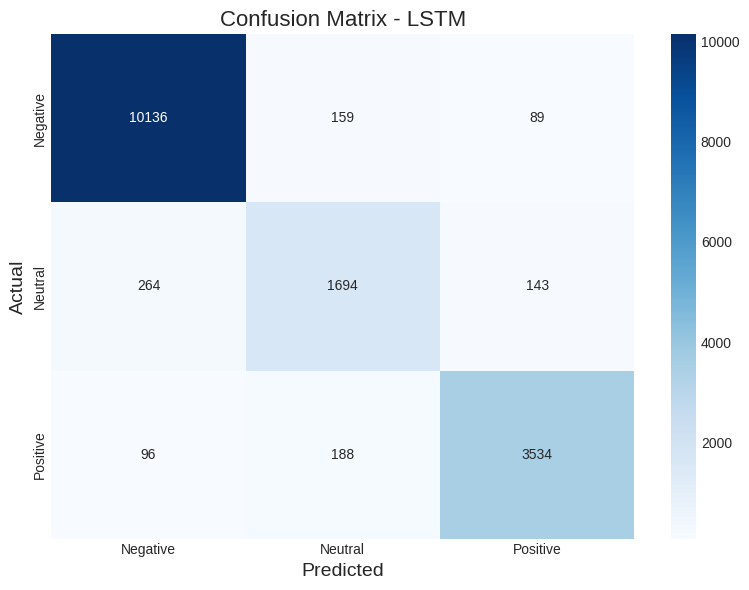


Class: Negative
  Precision: 0.9657
  Recall:    0.9761
  F1-score:  0.9709

Class: Neutral
  Precision: 0.8300
  Recall:    0.8063
  F1-score:  0.8180

Class: Positive
  Precision: 0.9384
  Recall:    0.9256
  F1-score:  0.9320

Random Forest Evaluation:
Accuracy: 0.8536

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.97      0.90     15638
     neutral       0.84      0.66      0.74      3111
    positive       0.90      0.64      0.75      5705

    accuracy                           0.85     24454
   macro avg       0.86      0.76      0.80     24454
weighted avg       0.86      0.85      0.85     24454



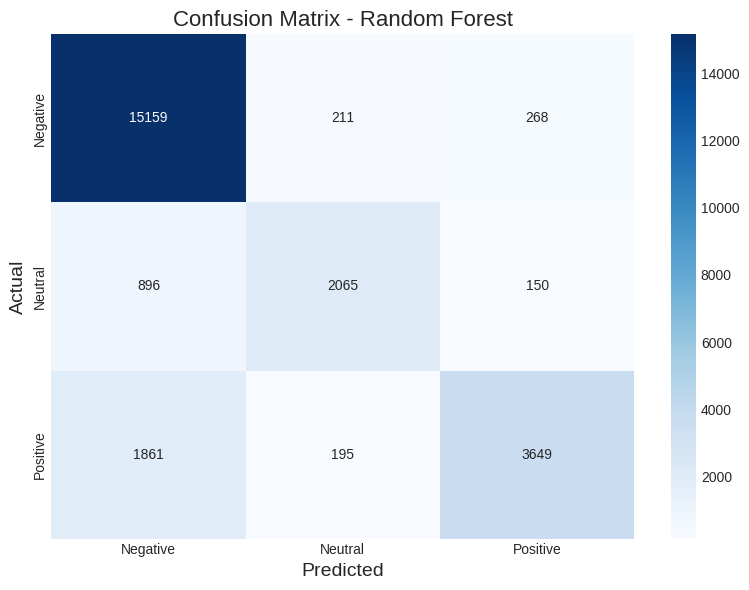


Class: Negative
  Precision: 0.8461
  Recall:    0.9694
  F1-score:  0.9036

Class: Neutral
  Precision: 0.8357
  Recall:    0.6638
  F1-score:  0.7399

Class: Positive
  Precision: 0.8972
  Recall:    0.6396
  F1-score:  0.7468

SVM Evaluation:
Accuracy: 0.9255

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.97      0.96     15638
     neutral       0.83      0.72      0.77      3111
    positive       0.92      0.90      0.91      5705

    accuracy                           0.93     24454
   macro avg       0.90      0.87      0.88     24454
weighted avg       0.92      0.93      0.92     24454



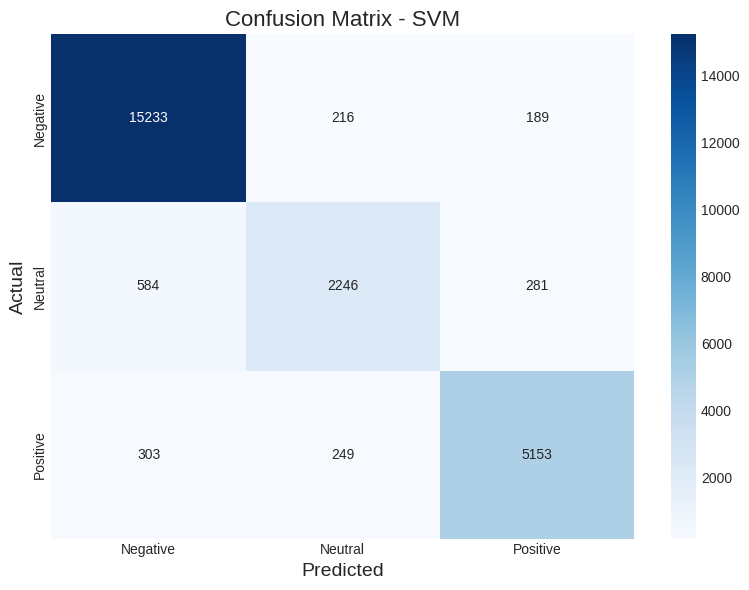


Class: Negative
  Precision: 0.9450
  Recall:    0.9741
  F1-score:  0.9593

Class: Neutral
  Precision: 0.8285
  Recall:    0.7220
  F1-score:  0.7716

Class: Positive
  Precision: 0.9164
  Recall:    0.9032
  F1-score:  0.9098


In [48]:
# Evaluate all models
evaluate_model(y_test_lstm, y_pred_lstm, "LSTM")
evaluate_model(y_test_rf, y_pred_rf, "Random Forest")
evaluate_model(y_test_svm, y_pred_svm, "SVM")

In [50]:
# Create a comparison table
model_comparison = pd.DataFrame({
    'Model': ['LSTM', 'Random Forest', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test_lstm, y_pred_lstm),
        accuracy_score(y_test_rf, y_pred_rf),
        accuracy_score(y_test_svm, y_pred_svm)
    ],
    'Data Split Ratio': ['80/20', '70/30', '70/30'],
    'Feature Type': ['Word Embedding', 'TF-IDF', 'TF-IDF']
})

# Format accuracy as percentage
model_comparison['Accuracy'] = model_comparison['Accuracy'].apply(lambda x: f"{x:.2%}")

# Display comparison table
print("\nModel Comparison:")
print(model_comparison)


Model Comparison:
           Model Accuracy Data Split Ratio    Feature Type
0           LSTM   94.24%            80/20  Word Embedding
1  Random Forest   85.36%            70/30          TF-IDF
2            SVM   92.55%            70/30          TF-IDF


Model LSTM mencapai akurasi terbaik (94.24%) dengan word embedding dan split ratio 80/20, mengungguli model SVM (92.55%) dan model Random Forest (85.36%) yang keduanya menggunakan TF-IDF dengan split ratio 70/30.

## Save Models

In [51]:
import os
if not os.path.exists("models"):
    os.makedirs("models")

# Save LSTM model
lstm_model.save("models/lstm_sentiment_model.h5")
print("LSTM model saved successfully.")

# Save Random Forest model
joblib.dump(rf_model, "models/rf_sentiment_model.joblib")
print("Random Forest model saved successfully.")

# Save SVM model
joblib.dump(svm_model, "models/svm_sentiment_model.joblib")
print("SVM model saved successfully.")

# Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer.joblib")
print("TF-IDF vectorizer saved successfully.")

# Save Sequence Tokenizer
joblib.dump(sequence_tokenizer, "models/sequence_tokenizer.joblib")
print("Sequence tokenizer saved successfully.")

LSTM model saved successfully.
Random Forest model saved successfully.
SVM model saved successfully.
TF-IDF vectorizer saved successfully.
Sequence tokenizer saved successfully.
